# Atooms and Postprocessing 

In this notebook, we are going to show how to perform standard analysis of molecular dynamics trajectories using the **atooms** and **postprocessing** libraries.

We start with loading common libraries for plotting and path handling.

In [1]:
%matplotlib inline
import pylab as pl
import sys

We the import the **postprocessing** libarry (available for Python 2.x) and the trajectory class from **atooms**. In this particular case, we will read an XYZ file, so we load the *TrajectoryXYZ* class

In [2]:
from atooms import postprocessing as pp
from atooms.trajectory import TrajectoryXYZ 

We consider an example trajectory, located in the postprocessing package.

In [7]:
path = "../../postprocessing/data/kalj-small.xyz"

## Handle a trajectory

A trajectory is an object with many properites. To load a trajectory, is sufficient to create in instance of the class as follows:

In [8]:
tj = TrajectoryXYZ(path)

The trajectory is a list-like object, in the sense that it can be sliced. Every slice contains a *System* object, which is a full configration of the system

In [9]:
print tj[10]

In [6]:
## To clarify: if I slice [a:b] I do not obtain a trajectory from a to b but a list
tj[10:15]

If the trajectory contains metadata, these can be retrieved directly:

In [7]:
print "Timestep during the trajectory:",tj.timestep
print "Steps for the 3rd frame:", tj.steps[2]
print tj._read_metadata(0)

Timestep during the trajectory: 0.001
Steps for the 3rd frame: 2000
{'ndim': 3, 'npart': 150, 'cell': [5.0, 5.0, 5.0], 'step': 0, 'dt': 0.001, 'columns': ['name', 'pos']}


## Analysis of the trajectory

Now that we have constructed a trajectory object, we can proceed to the analysis. We are going to consider two main aspects of the analysis:
* structural correlations
* dynamical correlations

### Structural correlations : computing the *radial distribution function*

The radial distribution function *g(r)* describes how density varies as a function of the radial distance from a reference particle. In liquids, one normally averages over all particles, obtaining a descriptor of the probability to find a second particle a distance $r$ from a given particle, relative to that of the ideal gas.

For $N$ particles of the same type at density $\rho$ it is

$$g(r)=\frac{1}{N\rho}\left\langle\sum_i^{N}\sum_{i\neq j}\delta(r-|\mathbf{r}_i-\mathbf{r}_j|)\right\rangle$$.

Notice that the average number of particles with a distance $R$, i.e. the average **coordination** $n(R)$,  can be computed from the radial distribution function via integration in spherical coordinates (for 3D systems)

$$n(R)=4\pi \rho\int_0^R g(r)r^2 dr$$

In *postprocessing* the radial distribution function is a correlation object that acts on a trajectory. In order to compute it, we simpy construct the object, specifying some parameters, and then run the calculation with the **.do()** method

In [8]:
gr = pp.RadialDistributionFunction(tj,norigins=5,dr=0.04)
gr.do()

Once the calculation is performed, the radial distribution object gr contains (like most correlators in *postprocessing*) two arrays:
* the **grid** array contains the indipendent variable, binned according to our input parameters (in this case, the smalleste space interval that we resolve, *dr*
* the **value** array contains the actual value of teh computation, in this case the values of the g(r)

We can directly plot the results with

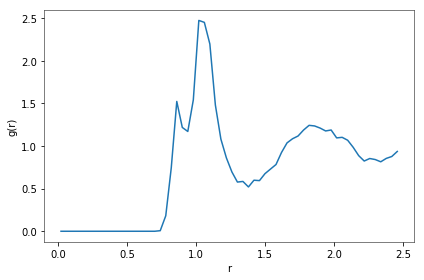

In [10]:
pl.plot(gr.grid,gr.value)
pl.xlabel("r"), pl.ylabel("g(r)");

As we can see, the function displays two narrow peaks around $r=1$ and a broader peak further away. The several peaks correspond to the fact that the trajectory actualy contains two types of particles, noted as "A" and "B". 

We can compute separate distribution functions for the A and B particles and also the cross distribution funtion for the probability to find a particle B at distance $r$ from particel $A$ using the **Partial** class in *postprocessing*:

In [12]:
gr = pp.Partial(pp.RadialDistributionFunction,species=['A','B'],trajectory=tj,norigins=100)
gr.do() 

In this case, the result contains a dictionary *gr.partial*:

In [13]:
type(gr.partial)

dict

We can treat the result as any norrmal dictionary: 

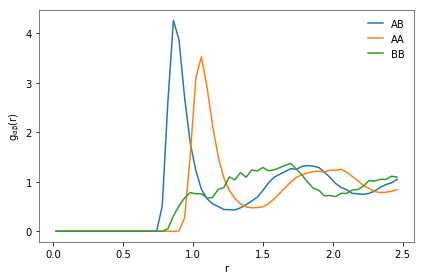

In [14]:
for key,g in gr.partial.items(): 
    pl.plot(g.grid, g.value, label=str("".join(key)))
pl.legend(),pl.xlabel("r"), pl.ylabel(r"$g_{\alpha\beta}(r)$");


Sometimes, it can be useful to analyse only sections of a trajectory. To this purpose, one can **slice** the trajectory using *atooms* and analyse individual frames or subsets of frames. 

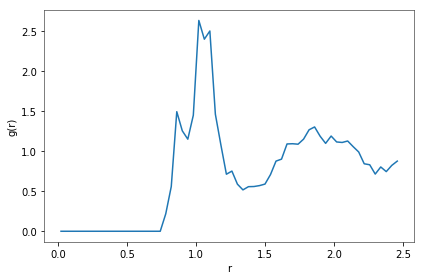

In [74]:
from atooms import trajectory

t =  trajectory.Sliced(tj,slice(-1,len(tj))) # analyse only the last frame
gr = pp.RadialDistributionFunction(t,dr=0.04)
gr.do()
pl.plot(gr.grid,gr.value)
pl.xlabel("r"), pl.ylabel("g(r)"); # notice that the g(r) is more noisy

### Dynamical Correlations: computing  the Mean Square Displacement

A very similar kind of anaysis can be performed on dynamical quantities, which quantify correlations in time.

The most elementary of such quantities is the mean squared displacement (MSD). This is defined as

$$ MSD(t)= \langle \mathbf{r}(t-t_0) - \mathbf{r}(t_0)\rangle$$

The average is normally perfomed over all the paricles $N$ and over multiple values for the *origin* of time $t_0$.

The analysis process is now familiar. First we cosntruct the msd object and then perform the calculation with **.do**.

In [16]:
msd = pp.MeanSquareDisplacement(tj)
msd.do()

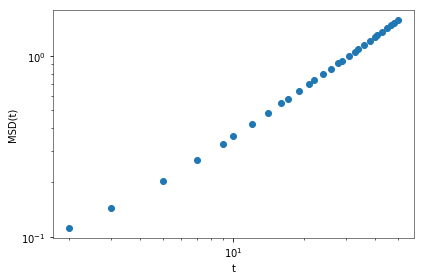

In [96]:
pl.loglog(msd.grid, msd.value,'o')
pl.xlabel("t"), pl.ylabel("MSD(t)");

Again, we can compute partial mean square displacements using the **Partial** class

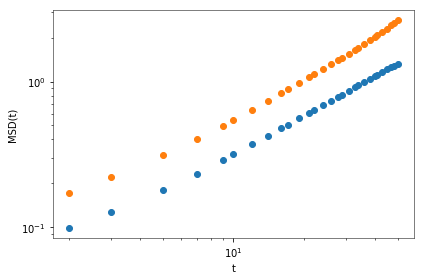

In [97]:
msds = pp.Partial(pp.MeanSquareDisplacement, species=['A','B'],trajectory=tj,norigins=100)
msds.do()
pl.loglog(msds.partial['A'].grid,msds.partial['A'].value,'o')
pl.loglog(msds.partial['B'].grid,msds.partial['B'].value,'o')
pl.xlabel("t"), pl.ylabel("MSD(t)");

## Computing the Self Intermediate Scattering Function

In [128]:
isf = pp.Partial(pp.SelfIntermediateScattering, species=["A"], trajectory= tj,kgrid=[2*pl.pi, 2.5*pl.pi],nk=1,tgrid=pl.logspace(0,3,base=10))
isf.do()
isf

In [119]:
# help(pp.SelfIntermediateScattering)

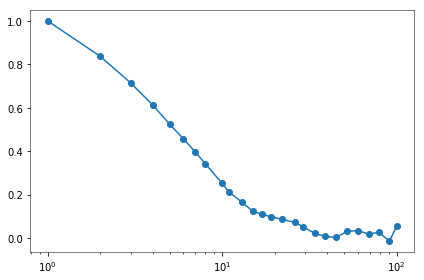

In [129]:
pl.semilogx(isf.partial['A'].grid[1],isf.partial['A'].value[0],'-o') 

In [124]:
isf.partial['A'].grid[1]

[1.0, 2.0, 5.0, 10.0, 22.0, 46.0, 100.0]

In [ ]:
pl.imshow(isf.partial['A'].grid[1],isf.partial['A'].value[0])

In [18]:
class OrderParameter(pp.correlation.Correlation):
    def __init__(self,trajectory,grid):
#         self.grid = grid
        pp.correlation.Correlation.__init__(self,trajectory,grid,phasespace=["pos"])
    
    def _compute(self):
        print "Hello"
#         self.grid = self._pos
#         self.value = self._pos[:,0]
#         self.b = self._pos
        
        

In [19]:
op = OrderParameter(tj,None)
op.compute()

Hello


(None, [])

In [17]:
pp.correlation.Correlation

atooms.postprocessing.correlation.Correlation